In [ ]:
!pip install geopandas
import pandas as pd
from geopandas.io.file import GeoDataFrame
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import geopandas as gpd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 8.9 MB/s 
     |████████████████████████████████| 6.3 MB 5.7 MB/s 
     |████████████████████████████████| 16.7 MB 41.6 MB/s 


## 행정동명, 행정코드, 법정코드 추가(카카오API 사용)

In [ ]:
import requests
df1=pd.read_csv('/content/drive/MyDrive/seoul/facility/보호주소.csv')
df2=pd.read_csv('/content/drive/MyDrive/seoul/facility/여가주소.csv')
df3=pd.read_csv('/content/drive/MyDrive/seoul/facility/의료주소.csv')
df4=pd.read_csv('/content/drive/MyDrive/seoul/facility/주거주소.csv')
df5=pd.read_csv('/content/drive/MyDrive/seoul/facility/재가주소.csv')
df6=pd.read_csv('/content/drive/MyDrive/seoul/facility/경로당주소.csv')
df_total=pd.concat([df1,df2,df3,df4,df5,df6])
addrs=df_total['시설주소']
addrs

0       서울특별시 서초구 남부순환로 2124까리따스종합복지관 (방배동)(방배동)
1                서울특별시 마포구 마포대로 182-10성촌빌딩 2층공덕동
2                   서울특별시 강북구 노해로 69대성빌딩 2층(수유동)
3               서울특별시 도봉구 도봉로108길 83-5 301호 (창동)
0                      서울특별시 성북구 화랑로18길 6 (상월곡동)
                          ...                   
3739                               서울특별시 강서구 마곡동
3740                               서울특별시 마포구 공덕동
3741                       서울특별시 영등포구 양평동3가 36번지
3742                               서울특별시 은평구 응암동
3743                 서울특별시 은평구 응암동 백련산힐스테이트2차아파트
Name: 시설주소, Length: 5063, dtype: object

In [ ]:
import requests
locations = []
for addr in addrs:
    url = 'https://dapi.kakao.com/v2/local/search/address.json?query={}'.format(addr)
    headers = {
    ## 여러분의 카카오 API의 REST API키를 아래 예시와 같이 입력해주세요
    ## "Authorization": "KakaoAK REST API키 입력 gogo"}
    "Authorization": "KakaoAK e834188bdff38f4ba019535b196a20b4"}
    place = requests.get(url, headers = headers).json()['documents']
    locations.append(place)
town = [] ## 동, 읍, 면
code=[] #행정동 코드
bcode=[] #행정동 코드
for i in range(len(locations)):
    
    try:
        town.append(locations[i][0].get('address').get('region_3depth_h_name'))
        code.append(locations[i][0].get('address').get('h_code'))
        bcode.append(locations[i][0].get('address').get('b_code'))
        
        
    except IndexError:
        print(i,'번째 주소 못가져옴', end ='')
        print()

        town.append('')
        code.append('')
        bcode.append('')
    
    except AttributeError:

        town.append(locations[i][0].get('road_address').get('region_3depth_h_name'))
        code.append(locations[i][0].get('address').get('h_code'))
        bcode.append(locations[i][0].get('address').get('b_code'))

In [ ]:
import numpy as np
town_code = np.array([town,code,bcode]).T
df_temp = pd.DataFrame(town_code, columns = ['region_3depth_h_name','h_code','b_code'])
df_temp.head()

,region_3depth_h_name,h_code,b_code
0,방배2동,1165061000,1165010100
1,공덕동,1144056500,1144010200
2,수유3동,1130563500,1130510300
3,창2동,1132051200,1132010700
4,월곡2동,1129072500,1129013700


In [ ]:
df_total['행정동명']=df_temp['region_3depth_h_name']
df_total['행정동코드']=df_temp['h_code']
df_total['법정동코드']=df_temp['b_code']
df_total.head()

,시설명,시설주소,Latitude,Longitude,자치구,행정동명,행정동코드,법정동코드
0,서울특별시남부노인보호전문기관,서울특별시 서초구 남부순환로 2124까리따스종합복지관 (방배동)(방배동),37.474521,126.984240,서초구,방배2동,1165061000,1165010100
1,중앙노인보호전문기관,서울특별시 마포구 마포대로 182-10성촌빌딩 2층공덕동,37.550143,126.955921,마포구,공덕동,1144056500,1144010200
2,서울특별시북부노인보호전문기관,서울특별시 강북구 노해로 69대성빌딩 2층(수유동),37.641736,127.022143,강북구,수유3동,1130563500,1130510300
3,서울시학대피해노인전용쉼터,서울특별시 도봉구 도봉로108길 83-5 301호 (창동),37.645949,127.038520,도봉구,창2동,1132051200,1132010700
0,성북구립 상월곡실버복지센터,서울특별시 성북구 화랑로18길 6 (상월곡동),37.605741,127.050871,성북구,방배2동,1165061000,1165010100


In [ ]:
df_total.to_csv('total.csv', index = False, encoding='utf-8-sig')


## 지도 시각화 (API에서 찾지못한 주소 처리 고민-일단 제거해서 테스트)

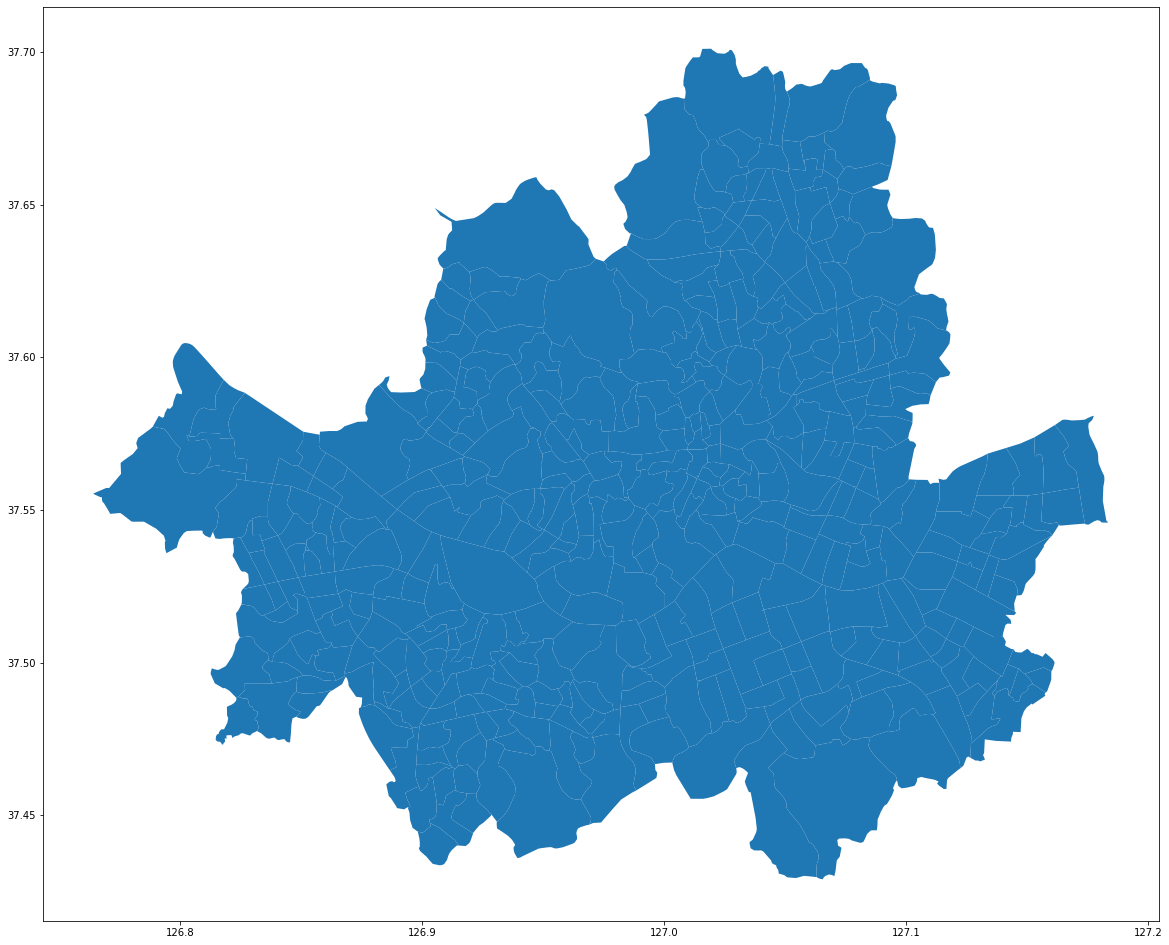

geopandas.geodataframe.GeoDataFrame

In [ ]:
plt.rcParams["figure.figsize"] = (20, 10) # 차트 사이즈
mpl.rcParams["axes.unicode_minus"] = False

"""노인보호전문기관"""
# 데이터 형식의 통일
#total_na - 불러오지못한 주소 삭제한 파일(5067 중 약 800개 없음)
data = pd.read_csv('/content/total_na.csv', encoding='utf-8')
n = data.shape[0]
adm_cd = []
for i in range(n):
    adm_cd.append(str(data['행정동코드'][i]))
data['adm_cd2'] = adm_cd
"""행정동 위치 파일과 결합"""
geo = gpd.read_file('/content/drive/MyDrive/DACON6/DACON_Lecture/data.shp',encoding='euc-kr')
geo
plt.rcParams['figure.figsize']=(20,20)
geo.plot()
plt.show()
df_geo= geo.iloc[:,[3,9]]
type(df_geo)

In [ ]:
from geopandas.io.file import GeoDataFrame
import matplotlib.pyplot as plt
import seaborn as sns
facility_count=data.groupby('adm_cd2',as_index=False)['시설명'].count()
facility_count['adm_cd2']=facility_count['adm_cd2'].astype(object)
facility_count=facility_count[['시설명','adm_cd2']]
facility_count=pd.DataFrame(facility_count)

type(facility_count)

cdata = pd.merge(facility_count, df_geo, on = 'adm_cd2',how='left')
data_merge = gpd.GeoDataFrame(cdata, crs="EPSG:4326", geometry="geometry")
cdata
from geopandas import GeoDataFrame

cdata = GeoDataFrame(cdata)

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44060 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 44060 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0, flags=flags)


<Figure size 1440x1440 with 0 Axes>

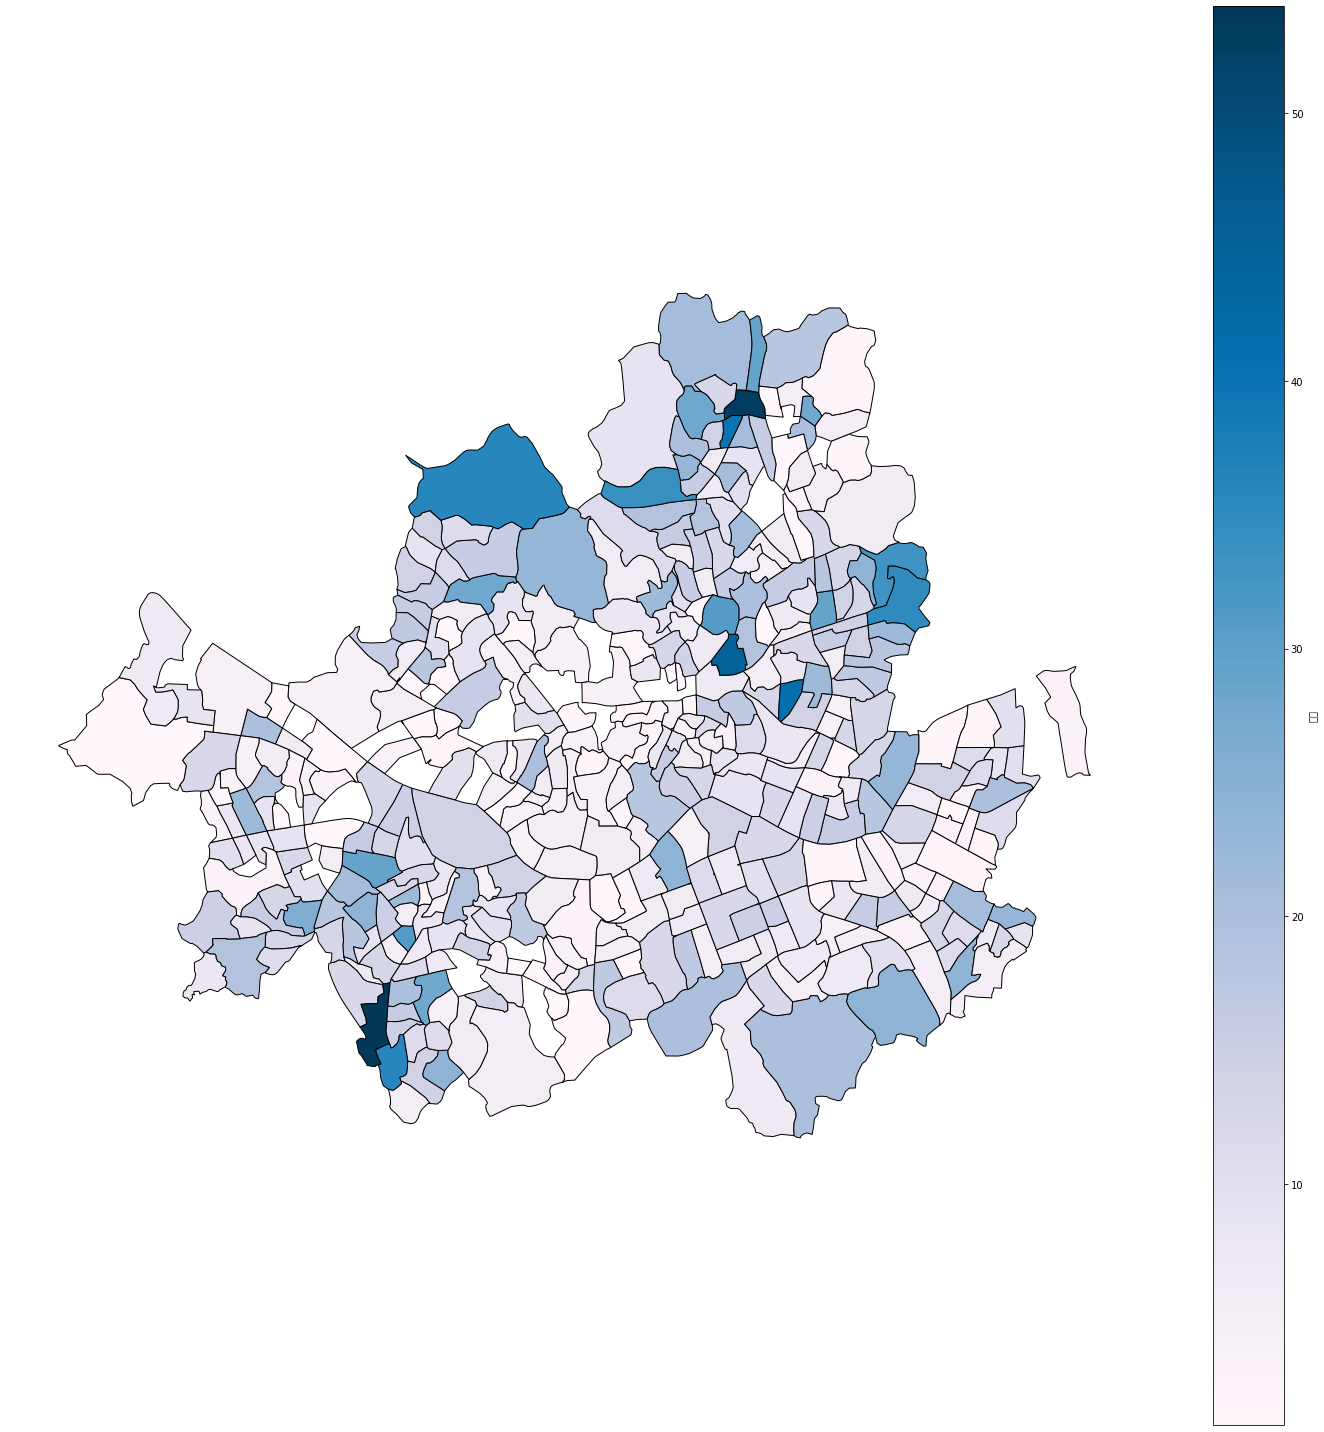

In [ ]:
fig = plt.figure()
cdata.plot(column='시설명',
                 legend=True,
                 cmap='PuBu',
                 edgecolor='k',
                 legend_kwds={'label': '개수'})
plt.axis('off')
plt.tight_layout()
plt.savefig('facility_ad.png')
plt.show()

# 주소처리 후 시설수 지도 데이터 시각화(네이버 지역검색API, 카카오API 사용)


In [ ]:
df_total.to_csv('total_final.csv',index=False,encoding='utf-8-sig')

In [ ]:
!pip install geopandas
import pandas as pd
from geopandas.io.file import GeoDataFrame
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import geopandas as gpd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 8.4 MB/s 
     |████████████████████████████████| 16.7 MB 46.7 MB/s 
     |████████████████████████████████| 6.3 MB 42.4 MB/s 


In [ ]:
plt.rcParams["figure.figsize"] = (20, 10) # 차트 사이즈
mpl.rcParams["axes.unicode_minus"] = False

"""노인보호전문기관"""
# 데이터 형식의 통일
data = pd.read_csv('/content/drive/MyDrive/seoul/total_final.csv', encoding='utf-8')
n = data.shape[0]
adm_cd = []
for i in range(n):
    adm_cd.append(str(data['행정동코드'][i]))
data['adm_cd2'] = adm_cd
"""행정동 위치 파일과 결합"""
geo = gpd.read_file('/content/drive/MyDrive/DACON6/DACON_Lecture/data.shp',encoding='euc-kr')
df_geo= geo.iloc[:,[3,9]]

,adm_cd2,geometry
0,1111053000,"MULTIPOLYGON (((126.97689 37.57565, 126.97703 ..."
1,1111054000,"MULTIPOLYGON (((126.98269 37.59507, 126.98337 ..."
2,1111055000,"MULTIPOLYGON (((126.97585 37.59656, 126.97359 ..."
3,1111056000,"MULTIPOLYGON (((126.97507 37.63139, 126.97649 ..."
4,1111057000,"MULTIPOLYGON (((126.96067 37.58080, 126.96281 ..."
...,...,...
420,1174070000,"MULTIPOLYGON (((127.15355 37.53400, 127.15357 ..."
421,1174057000,"MULTIPOLYGON (((127.14447 37.55477, 127.14319 ..."
422,1174061000,"MULTIPOLYGON (((127.13458 37.54712, 127.13115 ..."
423,1174068500,"MULTIPOLYGON (((127.14857 37.54578, 127.14871 ..."


In [ ]:
from geopandas.io.file import GeoDataFrame
import matplotlib.pyplot as plt
import seaborn as sns
facility_count=data.groupby('adm_cd2',as_index=False)['시설명'].count()
facility_count['adm_cd2']=facility_count['adm_cd2'].astype(object)
facility_count=facility_count[['시설명','adm_cd2']]
facility_count=pd.DataFrame(facility_count)

type(facility_count)

cdata = pd.merge(facility_count, df_geo, on = 'adm_cd2',how='left')
data_merge = gpd.GeoDataFrame(cdata, crs="EPSG:4326", geometry="geometry")
cdata
from geopandas import GeoDataFrame

cdata = GeoDataFrame(cdata)

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44060 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 44060 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0, flags=flags)


<Figure size 1440x720 with 0 Axes>

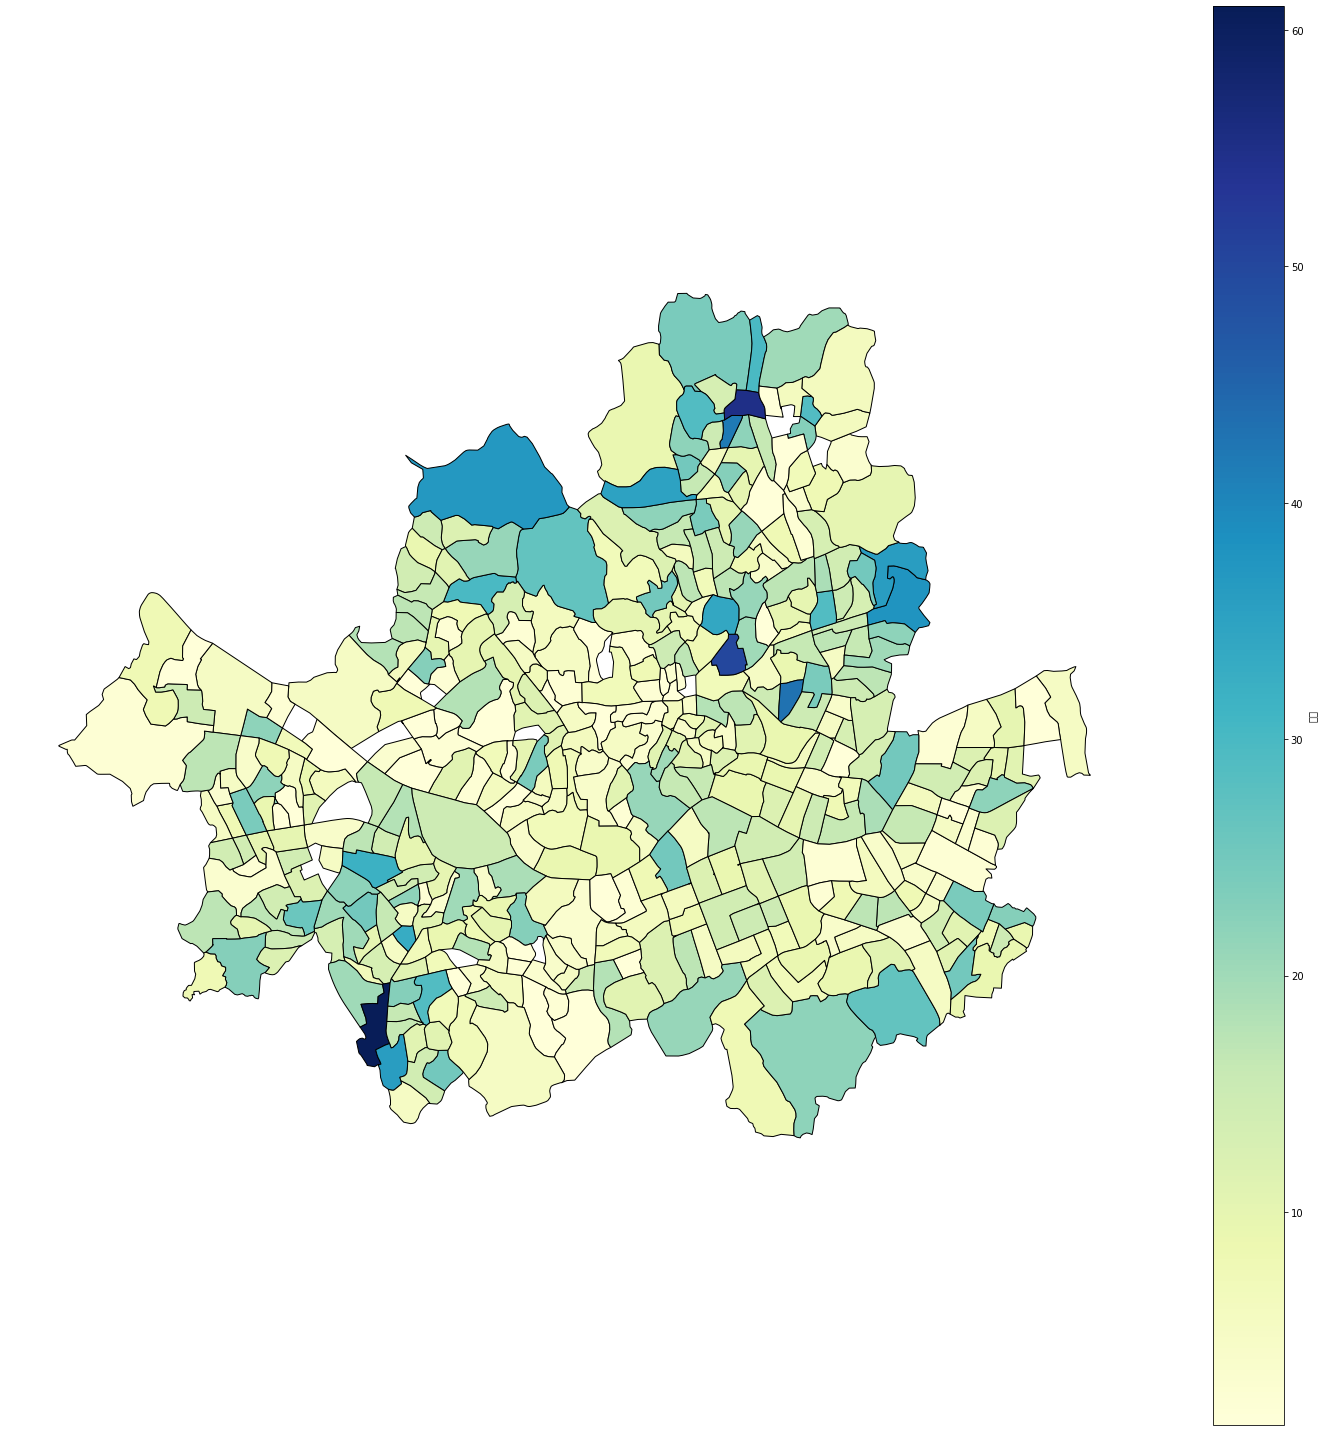

In [ ]:
fig = plt.figure()
plt.rcParams['figure.figsize']=(20,20)
cdata.plot(column='시설명',
                 legend=True,
                 cmap='YlGnBu',
                 edgecolor='k',
                 legend_kwds={'label': '개수'})
plt.axis('off')
plt.tight_layout()
plt.savefig('facility.png')
plt.show()